Imports

In [1114]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from plotting import plot_array
from soundGen import play
from pointsFrequency import signal_to_hertz
from filterAudio import low_pass_Filter, high_pass_Filter, dirac_comb_discrete
import torch
from torch_pitch_shift import pitch_shift
from numpy.random import uniform


Set universal variables above functions and declare them 

In [1115]:
Fs = 44100
T = 1/(Fs) 
N = Fs
amplitude = 2
frequency = [400, 200, 100]
t = 1
omega = 2 * np.pi


Then create code for signal

In [1116]:
t_vec = np.arange(N)*T*t 
ysum = 0
sine_add = np.sin(np.linspace(-16 * np.pi,16 * np.pi,len(t_vec)))/10
omega = 2 * np.pi* sine_add
for i in range(len(frequency)):
    ysum  += amplitude * np.sin(omega * frequency[i] * t_vec)


Normalize the signal


In [1117]:
normalized_y = ysum/ np.max(ysum)



Fix Reverb

In [1118]:
Duration_inp = 5
DryWet_ = 25
DryWet = abs((DryWet_/100)) # 1 = Wet, 0 = Dry


t = Duration_inp
length = len(normalized_y)
if Duration_inp == 1:
    Duration_inp = 2
t = Duration_inp
Duration = Duration_inp
total_len = int(Duration * length)
t_vec_r = np.arange(int(N * Duration)) * T * t
x = float(length/(total_len))

#First output original sample

length1 = int(total_len * (x)) 
length2 = int(total_len * ((Duration_inp-1) * x/3)) + length1
length3 = int(total_len * ((Duration_inp-1) * x/4)) + length2
length4 = int(total_len * ((Duration_inp-1) * x/6)) + length3
length5 = int(total_len * ((Duration_inp-1) * x/6)) + length4
length6 = int(total_len * ((Duration_inp-1) * x/12)) + length5


""" releaseg = np.ones_like(t_vec_r)
releaseh = np.ones_like(t_vec_r)
releasek = np.ones_like(t_vec_r)
releasej = np.ones_like(t_vec_r)
releasel = np.ones_like(t_vec_r)
if Duration_inp >= 3: """
releaseg = np.linspace(1,0.75, length2 - length1+1)
releaseh = np.linspace(1,0.5, length3 - length2+1)
releasek = np.linspace(1,0.5, length4 - length3)
releasej = np.linspace(1,0.5, length5 - length4)
releasel = np.linspace(1,0.5, length6 - length5)

cych = 2205
cyc3h = 3 * cych
cyc5h = 5 * cych
cyc7h = 7 * cych
cyc9h = 9 * cych
norm_y_a = normalized_y.copy()
norm_y = list(norm_y_a) * int((Duration))

conv_y = np.zeros_like(t_vec_r)

if DryWet == 0.0:
    D1 = 1; D2 = 1; D3 = 1; D4 = 1; D5 = 1

elif DryWet == 1:
    a = 1
    D1 = 1 - 0.9 * DryWet*a; D2 = 1 - 0.8 * DryWet*a; D3 = 1 - 0.7 * DryWet*a
    D4 = 1 - 0.7 * DryWet*a; D5 = 1 - 0.6 * DryWet*a


elif 0.75 <= DryWet < 1:
    a = 1.2 + (1 - DryWet)*2.75
    D1 = 1 - 0.9 * DryWet*a; D2 = 1 - 0.8 * DryWet*a; D3 = 1 - 0.7 * DryWet*a
    D4 = 1 - 0.7 * DryWet*a; D5 = 1 - 0.6 * DryWet*a

elif 0.5 <= DryWet < 0.75:
    a = 2 + (1 - DryWet - 0.3) * 3.5
    D1 = 1 - 0.9 * DryWet*a; D2 = 1 - 0.8 * DryWet*a; D3 = 1 - 0.7 * DryWet*a
    D4 = 1 - 0.7 * DryWet*a; D5 = 1 - 0.6 * DryWet*a


elif 0.25 <= DryWet < 0.5:
    b = 8 - abs(1 - DryWet*4)*8
    D1 = 1 - 0.9 * DryWet*b; D2 = 1 - 0.8 * DryWet*b; D3 = 1 - 0.7 * DryWet*b
    D4 = 1 - 0.7 * DryWet*b; D5 = 1 - 0.6 * DryWet*b

elif 0 < DryWet < 0.25:
    b = 0.1
    D1 = 1 - 0.9 * DryWet*b; D2 = 1 - 0.8 * DryWet*b; D3 = 1 - 0.7 * DryWet*b
    D4 = 1 - 0.7 * DryWet*b; D5 = 1 - 0.6 * DryWet*b
#Release constants
g = 0; h = 0; k = 0; j = 0; l = 0

0.25


In [1119]:


for n in range(len(t_vec_r)):
    
    if n >= length1 and n < length2:
        conv_y[n] = releaseg[g] * (norm_y[n] * D1 - norm_y[n-length1+cych]*0.9 * DryWet)
        g += 1

    elif n >= length2 and n <= length3:
        conv_y[n] = releaseh[h] * (norm_y[n- length2] * D2 - norm_y[n-length2+cych]*0.3 * DryWet - norm_y[n- length2+cyc3h]*0.3  * DryWet\
            - norm_y[n- length2+cyc5h]*0.1 * DryWet - norm_y[n- length2+cyc7h]*0.15 * DryWet)
        h += 1 

    elif n >= length3 and n <= length4:
        conv_y[n] = releasek[k] * (norm_y[n-length3] * D3 - norm_y[n-length3+cych]*0.3 * DryWet\
            - norm_y[n- length3+cyc3h]*0.2 * DryWet - norm_y[n- length3+cyc5h]*0.1 * DryWet - norm_y[n- length3+cyc7h]*0.1 * DryWet)
        k += 1

    elif n >= length4 and n <= length5:
        conv_y[n] = releasej[j] * (norm_y[n-length4] * D4 - norm_y[n-length4+cych]*0.2 * DryWet - norm_y[n- length4+cyc3h]*0.2 * DryWet\
            - norm_y[n- length4+cyc5h]*0.1 * DryWet - norm_y[n - length4+cyc7h]*0.05 * DryWet - norm_y[n - length4+cyc9h]*0.05 * DryWet)
        j += 1
        
    elif n >= length5 and n < length6:
        dist = n - length5
        conv_y[n] =  releasel[l] * (norm_y[dist] * D5 - norm_y[dist+cych]*0.2 * DryWet - norm_y[dist+cyc3h]*0.15 * DryWet\
            - norm_y[dist+cyc5h]*0.05 * DryWet - norm_y[dist+cyc7h]*0.05 * DryWet - norm_y[dist+cyc9h]*0.05 * DryWet)
        l += 1

    else:
        
        conv_y[n] = norm_y[n]

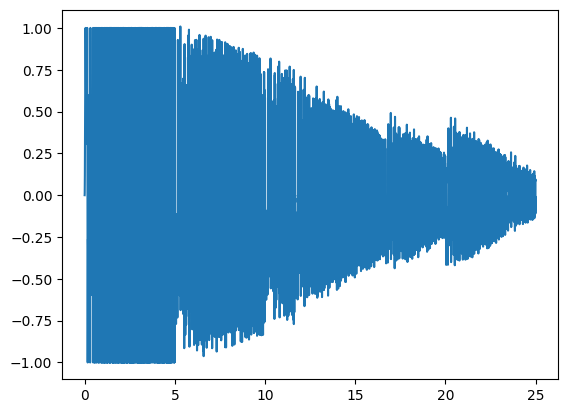

In [1120]:
plt.plot(t_vec_r, conv_y)
play(conv_y)